# Introduction to Asymptotic Analysis

## What is this about?
The idea is to give a high-level overview of the analysis of algorithmic complexity, with some examples of real-world algorithms in Python, and their asymptotic behaviour. I will skip over most of the mathematical details, but will introduce $O$ notation for describing runtime complexity.

## A motivating example: how long does it take to sort a list of numbers?

Let's try sorting a large list, say 1 million random floating point numbers...

In [51]:
one_million = 1000000
list_of_random_numbers = numpy.random.rand(one_million)
time_to_sort = time_function(numpy.sort, (list_of_random_numbers,))

print(f"It takes {time_to_sort:0.2f} ms to sort {one_million} random values")

It takes 0.10 ms to sort 1000000 random values


Ok, but this is not particularly useful; the value fluctuates depending on the exact set of random numbers generated and, unless we only ever want to sort arrays of 1 million values then we need more... what we really want to know is how does the run-time depend on the size ($N$) of the input array, so let's look at that...

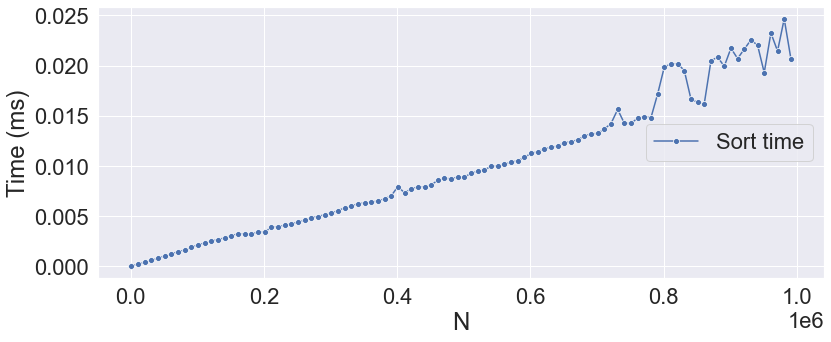

In [53]:
import numpy
import seaborn
import pandas
import matplotlib.pyplot as plt

from algorithm_utils import *

seaborn.set(font_scale=2)

min_size = 1000
max_size = 1000000
increment = 10000
x_axis_label = "N"
y_axis_label = "Time (ms)"

lists = [
    numpy.random.rand(x) for x in range(min_size, max_size, increment)
]

list_lengths = [len(x) for x in lists]
sort_times = [time_function(numpy.sort, (x,)) for x in lists]

data = pandas.DataFrame({
    x_axis_label: list_lengths, 
    y_axis_label: normalize(sort_times)
})

plt.rcParams['figure.figsize'] = [13, 5]
seaborn.lineplot(x=x_axis_label, y=y_axis_label, data=data, marker='o')
plt.legend(labels=["Sort time"], loc="right");

Some obvious features of this graph:
* Sort-time increases with the size of the input array
* The relationship between size and sort-time looks fairly smooth for most of the graph, and is almost a straight line

**Q**: is there perhaps a mathematical relationship between $N$ and the sort-time?   
**A**: yes, but it's pretty complicated, and depends entirely on the details of the sort function

**Q**: is it possible to actually calculate the run-time from $N$ using some kind of equation?   
**A**: you don't want to see that equation... also no, not really, there are too many variables involved, and it is much easier to just run the function and time it than it is to construct a crazy equation like that.

**Q**: Ok, we can't get an exact calculation, but maybe we can describe the shape of the relationship? That would help us to see how sort-time depends on $N$?
**A**: we can do that, and there are some nice mathematical tools that will help us. Let's start by looking at a few simple mathematical relationships, and see if anything looks similar to our graph...

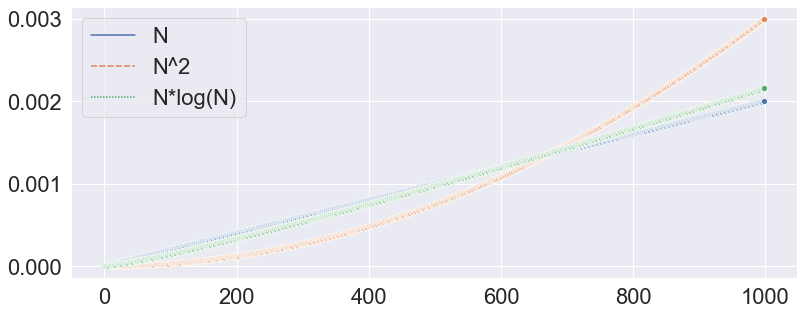

In [61]:
from math import log, exp

n_values = range(1, 1000)
n = normalize(n_values)
n_squared = normalize([n**2 for n in n_values])
n_log_n = normalize([n*log(n) for n in n_values])
#exp_n = [exp(n) for n in n_values]

data = pandas.DataFrame({
    "N": n, 
    "N^2": n_squared,
    "N*log(N)": n_log_n
})

plt.rcParams['figure.figsize'] = [13, 5]
seaborn.lineplot(data=data, marker='o');